In [1]:
! pip install ffmpeg

In [12]:
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

import snntorch as snn
from snntorch import surrogate, backprop, spikegen, utils
from snntorch import functional as SF
from snntorch import spikeplot as splt


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# parameters
num_steps = 100


# transform composer
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (1,)),
    ]
)

# data handlers
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

<h1> Converting the physical data spike </h1>
<p>we are using rate coding to encode. After creating an iterator it will select the first batch and calls the next iterator and converts all the images of that batch to spike </p> 

In [4]:
# Create a iterator for the dataloader
data = iter(trainloader)
# Get the next batch
images, labels = next(data)

print(images.size())
# creating spike data
spikes = spikegen.rate(images, num_steps=num_steps)

torch.Size([32, 1, 28, 28])


**visualizing the sample**

In [5]:
print(f"total spike size {spikes.size()}")
# selects a sample from the batch to visualize
sample_num = 31
spike_sample = spikes[:,sample_num,0]
print(f"Label {labels[sample_num]}")
print(spike_sample.size())

total spike size torch.Size([100, 32, 1, 28, 28])
Label 5
torch.Size([100, 28, 28])


MovieWriter ffmpeg unavailable; using Pillow instead.


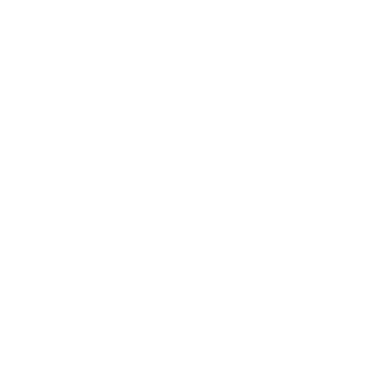

In [6]:
fig, ax = plt.subplots()
anim = splt.animator(spike_sample, fig, ax)
anim.save("spike.gif")

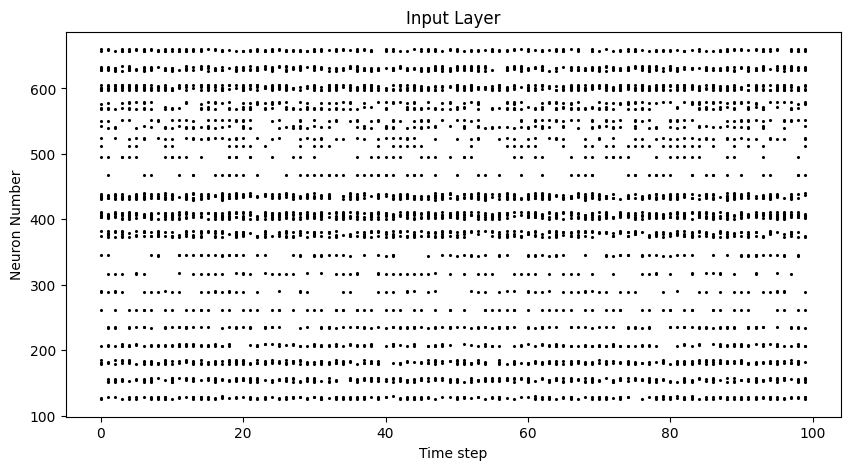

In [7]:
# Reshape
spike_sample= spike_sample.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_sample, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
# plt.show()
plt.savefig("raster.png")

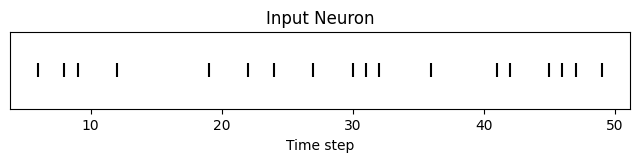

In [19]:
idx = 209

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

In [10]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [15]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(32, -1))
        spk3, mem3 = self.lif3(cur3, mem3)

        return spk3, mem3

In [16]:
#  Initialize Network
net = nn.Sequential(
    nn.Conv2d(1, 12, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 64, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True),
).to(device)

In [17]:
from torchsummary import summary
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 24, 24]             312
         MaxPool2d-2           [-1, 12, 12, 12]               0
             Leaky-3           [-1, 12, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          19,264
         MaxPool2d-5             [-1, 64, 4, 4]               0
             Leaky-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 10]          10,250
             Leaky-9       [[-1, 10], [-1, 10]]               0
Total params: 29,826
Trainable params: 29,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.11
Estimated Total Size (MB): 0.25
---------------------------------------------